In [1]:
import os
import pandas as pd
import numpy as np
import napari
from tifffile import imread
from skimage.io import imread as imread_sk
from skimage.measure import regionprops_table
from skimage.segmentation import clear_border
from scipy.spatial import distance_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from helper_functions import labels_from_df

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
df_path = r'D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\230117_exp_summary.pkl'

cd44_mask_dir = r'D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_CD44'
dna_mask_dir = r'D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_DNA_4'

In [20]:
df = pd.read_pickle(df_path)

In [21]:
df

,file_name,exp_dir,im_path,slide,well,exp,marker,dye,im_round,density,donor,treatment
0,T3737_9_2_1.0.4_R000_Cy3_CycB1-AF555_FINAL_AFR...,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_C...,T3737_9_2,R000,T3737_9_2_R000,CycB1,Cy3,1,150,D1,0
1,T3737_9_2_1.0.4_R000_Cy5_CD8a-AF647_FINAL_AFR_...,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_C...,T3737_9_2,R000,T3737_9_2_R000,CD8a,Cy5,1,150,D1,0
2,T3737_9_2_1.0.4_R000_Cy7_CD44-AF750_FINAL_AFR_...,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_C...,T3737_9_2,R000,T3737_9_2_R000,CD44,Cy7,1,150,D1,0
3,T3737_9_2_1.0.4_R000_DAPI__FINAL_F.tif,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_D...,T3737_9_2,R000,T3737_9_2_R000,DNA_01,DAPI,1,150,D1,0
4,T3737_9_2_1.0.4_R000_FITC_PCNA-AF488_FINAL_AFR...,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_F...,T3737_9_2,R000,T3737_9_2_R000,PCNA,FITC,1,150,D1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
315,T3937_39_4.0.4_R007_Cy3_p21-AF555_FINAL_AFR_F.tif,D:\data\T3937_39_Final,D:\data\T3937_39_Final\T3937_39_4.0.4_R007_Cy3...,T3937_39,R007,T3937_39_R007,p21,Cy3,4,200,D2,24
316,T3937_39_4.0.4_R007_Cy5_FoxP3-AF647_FINAL_AFR_...,D:\data\T3937_39_Final,D:\data\T3937_39_Final\T3937_39_4.0.4_R007_Cy5...,T3937_39,R007,T3937_39_R007,FoxP3,Cy5,4,200,D2,24
317,T3937_39_4.0.4_R007_Cy7_cycB2-AF750_FINAL_AFR_...,D:\data\T3937_39_Final,D:\data\T3937_39_Final\T3937_39_4.0.4_R007_Cy7...,T3937_39,R007,T3937_39_R007,cycB2,Cy7,4,200,D2,24
318,T3937_39_4.0.4_R007_DAPI__FINAL_F.tif,D:\data\T3937_39_Final,D:\data\T3937_39_Final\T3937_39_4.0.4_R007_DAP...,T3937_39,R007,T3937_39_R007,DNA_04,DAPI,4,200,D2,24


In [51]:
exp_sel = 'T3937_39_R003'#'T3937_39_R001' T3737_9_2_R003

df_sel = df.loc[df.exp==exp_sel,:]


dna_path = df_sel.loc[df_sel.marker=='DNA_04','im_path'].tolist()[0]
dna_im_name = df_sel.loc[df_sel.marker=='DNA_04','file_name'].tolist()[0]
dna_mask_path = os.path.join(dna_mask_dir,dna_im_name.replace('.tif','_maskdna4.png'))

cd44_path = df_sel.loc[df_sel.marker=='CD44','im_path'].tolist()[0]
cd44_im_name = df_sel.loc[df_sel.marker=='CD44','file_name'].tolist()[0]
cd44_mask_path = os.path.join(cd44_mask_dir,cd44_im_name.replace('.tif','_maskcd44.png'))

dna_im = imread(dna_path)
dna_mask = imread_sk(dna_mask_path)
cd44_im = imread(cd44_path)
cd44_mask = imread_sk(cd44_mask_path)

In [52]:
# create test images

test_size = 2000
im_shape = dna_im.shape

dna_im_small = dna_im[int((im_shape[0]-test_size)/2):int((im_shape[0]+test_size)/2),int((im_shape[1]-test_size)/2):int((im_shape[1]+test_size)/2)]
dna_mask_small = dna_mask[int((im_shape[0]-test_size)/2):int((im_shape[0]+test_size)/2),int((im_shape[1]-test_size)/2):int((im_shape[1]+test_size)/2)]
cd44_im_small = cd44_im[int((im_shape[0]-test_size)/2):int((im_shape[0]+test_size)/2),int((im_shape[1]-test_size)/2):int((im_shape[1]+test_size)/2)]
cd44_mask_small = cd44_mask[int((im_shape[0]-test_size)/2):int((im_shape[0]+test_size)/2),int((im_shape[1]-test_size)/2):int((im_shape[1]+test_size)/2)]

In [53]:
# initital visualization

viewer = napari.Viewer()
viewer.add_image(dna_im_small,blending='additive',colormap='green')
viewer.add_image(cd44_im_small,blending='additive',colormap='red')
viewer.add_labels(dna_mask_small,blending='additive')
viewer.add_labels(cd44_mask_small,blending='additive')

<Labels layer 'cd44_mask_small' at 0x23fb3868c70>

In [54]:
properties = ['label','centroid','bbox','area','solidity','eccentricity','image','mean_intensity']

In [55]:
# clear border objects
dna_mask_small = clear_border(dna_mask_small,buffer_size=1)
cd44_mask_small = clear_border(cd44_mask_small,buffer_size=1)

# calculate properties
dna_data = regionprops_table(dna_mask_small,intensity_image=(cd44_mask_small>0),properties=properties)
df_dna = pd.DataFrame(dna_data)
print(len(df_dna))

cd44_data = regionprops_table(cd44_mask_small,intensity_image=(dna_mask_small>0),properties=properties)
df_cd44 = pd.DataFrame(cd44_data)
print(len(df_cd44))

180
179


In [56]:
df_dna

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area,solidity,eccentricity,image,mean_intensity
0,11157,18.049080,1611.187117,10,1600,28,1623,326,0.967359,0.617346,"[[False, False, False, False, False, False, Fa...",1.000000
1,11165,34.250000,1672.829268,23,1663,45,1683,328,0.973294,0.490809,"[[False, False, False, False, False, False, Fa...",0.957317
2,11167,36.759894,156.883905,26,147,48,168,379,0.969309,0.373239,"[[False, False, False, False, False, False, Fa...",0.994723
3,11171,37.716612,1627.547231,29,1617,47,1639,307,0.953416,0.605848,"[[False, False, False, False, False, False, Fa...",1.000000
4,11182,43.700599,1695.970060,34,1687,55,1706,334,0.988166,0.426079,"[[False, False, False, False, True, True, True...",1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
175,13023,1878.188889,1183.205556,1868,1173,1890,1194,360,0.965147,0.517083,"[[False, False, False, False, False, False, Fa...",1.000000
176,13026,1881.184848,455.690909,1871,446,1892,466,330,0.976331,0.572720,"[[False, False, False, False, False, False, Tr...",1.000000
177,13044,1899.964187,1963.355372,1889,1953,1912,1974,363,0.965426,0.347311,"[[False, False, False, False, False, False, Fa...",1.000000
178,13057,1915.555224,426.304478,1905,417,1927,437,335,0.965418,0.528976,"[[False, False, False, False, False, False, Fa...",1.000000


<AxesSubplot: xlabel='mean_intensity', ylabel='Count'>

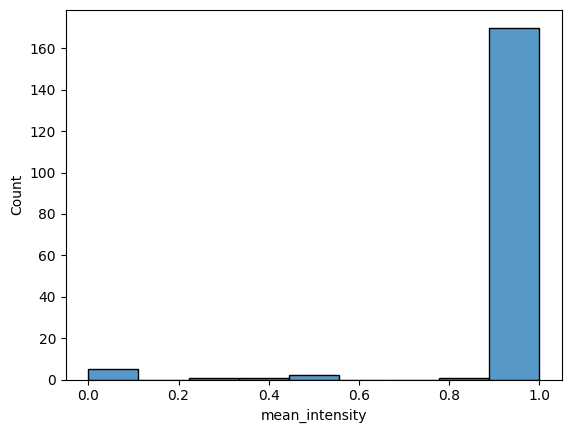

In [57]:
sns.histplot(data = df_dna,x='mean_intensity')

In [58]:
# select objects based on the shape characteristics
df_dna_sel = df_dna.loc[((df_dna.area > 250) & (df_dna.area < 1000)),:]
df_dna_sel = df_dna_sel.loc[(df_dna_sel.eccentricity < 0.75),:]
df_dna_sel = df_dna_sel.loc[(df_dna_sel.solidity > 0.9),:]
print(len(df_dna_sel))

df_cd44_sel = df_cd44.loc[((df_cd44.area > 250) & (df_cd44.area < 2000)),:]
df_cd44_sel = df_cd44_sel.loc[(df_cd44_sel.eccentricity < 0.75),:]
df_cd44_sel = df_cd44_sel.loc[(df_cd44_sel.solidity > 0.8),:]
print(len(df_cd44_sel))

174
173


In [59]:
# select objects based on the presence of matching partner
df_dna_sel = df_dna_sel.loc[(df_dna_sel.mean_intensity > 0.6),:]
print(len(df_dna_sel))

df_cd44_sel = df_cd44_sel.loc[(df_cd44_sel.mean_intensity > 0.2),:]
print(len(df_cd44_sel))

168
171


In [60]:
# match objects

dist_mat = distance_matrix(df_dna_sel.loc[:,['centroid-0','centroid-1']],df_cd44_sel.loc[:,['centroid-0','centroid-1']])

In [61]:
# choose dna objects that have only one close cyto object
dist_mat_bin = dist_mat < 10
dna_to_cyto_match = np.sum(dist_mat_bin,axis=1)
sel_vec = (dna_to_cyto_match==1)

df_dna_match = df_dna_sel.loc[sel_vec,:]

# find label of the matching cyto object
dna_min_partner_iloc = np.argmin(dist_mat,axis=1)
dna_min_partner_label = np.array(df_cd44_sel.label.tolist())[dna_min_partner_iloc][sel_vec]
df_dna_match['cyto_match'] = dna_min_partner_label

print(f'Number of nuclear objects that match to cyto objects: {len(df_dna_match)}')

# look for cyto that matched to more than one dna
print(f'Number of cyto objects that matched to more than 1 nuclear object: {np.sum(df_dna_match.cyto_match.duplicated())}')

df_dna_match = df_dna_match.drop(df_dna_match.index[df_dna_match.cyto_match.duplicated()])

print(f'Number of accepted pairs: {len(df_dna_match)}')

Number of nuclear objects that match to cyto objects: 168
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 168


In [62]:
# merge 

df1 = df_dna_match.loc[:,['image','cyto_match','bbox-0','bbox-1','bbox-2','bbox-3']]
df2 = df_cd44_sel.loc[:,['image','label','bbox-0','bbox-1','bbox-2','bbox-3']]

df_obj = pd.merge(left=df1,right=df2,left_on='cyto_match',right_on='label',how='inner',suffixes=('_nuc','_cyto'))

df_obj['label'] = df_obj.index+1
df_obj

,image_nuc,cyto_match,bbox-0_nuc,bbox-1_nuc,bbox-2_nuc,bbox-3_nuc,image_cyto,label,bbox-0_cyto,bbox-1_cyto,bbox-2_cyto,bbox-3_cyto
0,"[[False, False, False, False, False, False, Fa...",11526,10,1600,28,1623,"[[False, False, False, False, False, False, Fa...",1,4,1599,29,1627
1,"[[False, False, False, False, False, False, Fa...",11534,23,1663,45,1683,"[[False, False, False, False, False, False, Fa...",2,20,1664,45,1685
2,"[[False, False, False, False, False, False, Fa...",11539,26,147,48,168,"[[False, False, False, False, False, False, Fa...",3,25,146,50,169
3,"[[False, False, False, False, False, False, Fa...",11542,29,1617,47,1639,"[[False, False, False, False, False, False, Fa...",4,27,1616,50,1640
4,"[[False, False, False, False, True, True, True...",11552,34,1687,55,1706,"[[False, True, True, True, True, True, True, T...",5,31,1683,55,1707
...,...,...,...,...,...,...,...,...,...,...,...,...
163,"[[False, False, False, False, False, False, Fa...",13427,1868,1173,1890,1194,"[[False, False, False, False, False, False, Fa...",164,1865,1170,1894,1198
164,"[[False, False, False, False, False, False, Tr...",13430,1871,446,1892,466,"[[False, False, False, False, False, False, Fa...",165,1870,445,1893,470
165,"[[False, False, False, False, False, False, Fa...",13447,1889,1953,1912,1974,"[[False, False, False, False, False, False, Fa...",166,1887,1950,1913,1975
166,"[[False, False, False, False, False, False, Fa...",13458,1905,417,1927,437,"[[False, False, False, False, False, False, Fa...",167,1903,415,1928,438


In [63]:
im_shape = dna_im_small.shape

dna_sel_labels = labels_from_df(df_obj,im_shape = im_shape,label='label',image='image_nuc',bbox_suffix='_nuc')
cd44_sel_labels = labels_from_df(df_obj,im_shape = im_shape,label='label',image='image_cyto',bbox_suffix='_cyto')

In [64]:
viewer.add_labels(dna_sel_labels)
viewer.add_labels(cd44_sel_labels)

<Labels layer 'cd44_sel_labels' at 0x23fa40fa5b0>